# Descripcion del proyecto

Se trabaja con un dataser de una empresa emergente que vende productos alimenticios. 

**objetivo:** investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Con los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.



## Leer el archivo e información general

In [1]:
#Importamos librerias
import pandas as pd
import datetime
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
#Lectura general de los datos
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

#Información general
data.info()

# 5 primeras filas del archivo
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Preparar los datos para el analisis

In [4]:
# Renombramos columnas
data = data.rename(columns={'EventName': 'nombre_event', 'DeviceIDHash': 'id_usuario', 'EventTimestamp': 'hora_event', 'ExpId': 'numero_experimento'})

# Convertimos la columna 'hora_event' a datetime
data['hora_event'] = pd.to_datetime(data['hora_event'], unit='s')

#mostramos las filas con valores duplicados
dupli = data[data.duplicated()]

#Agregamos columna de fecha
data['date'] = data['hora_event'].dt.date
data['date'] = pd.to_datetime(data['date'])
 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   nombre_event        244126 non-null  object        
 1   id_usuario          244126 non-null  int64         
 2   hora_event          244126 non-null  datetime64[ns]
 3   numero_experimento  244126 non-null  int64         
 4   date                244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
data.head(2)

,nombre_event,id_usuario,hora_event,numero_experimento,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [7]:
data['nombre_event'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: nombre_event, dtype: int64

Eventos:
   - MainScreenAppear        :  Aparece la pantalla principal
   - OffersScreenAppear      :  Aparece la pantalla de ofertas
   - CartScreenAppear        :  Aparece la pantalla del carrito
   - PaymentScreenSuccessful :  Pantalla de pago exitosa
   - Tutorial                :  Tutorial

### ¿Cuántos usuarios hay en los registros?

In [8]:
print("Usuarios en los registros:", data['id_usuario'].nunique())
print()
#Usuario por evento
print("Usuarios por cada evento")
usuarios = data.groupby('nombre_event').agg({'id_usuario': 'nunique'}).reset_index()
usuarios.sort_values(by = 'id_usuario', ascending=False)

Usuarios en los registros: 7551

Usuarios por cada evento


,nombre_event,id_usuario
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
0,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


De 7439 usuarios que entraron a la pantalla principal solo el 62% ingreso a la pantalla de ofertas.
De 3749 usuarios que ingresaron a la pantalla de carrito, el 94.6% completo el pago exitoso.

### ¿Cuál es el promedio de eventos por usuario?

In [9]:
num_events = data.shape[0]
num_users = data['id_usuario'].nunique()
avg_events_per_user = num_events / num_users
print(f"El promedio de eventos por usuario es {avg_events_per_user:.0f}")

El promedio de eventos por usuario es 32


### ¿Qué periodo de tiempo cubren los datos? 

In [10]:
#Buscamos fecha max y mn
print(data['date'].min())
data['date'].max()

2019-07-25 00:00:00


Timestamp('2019-08-07 00:00:00')

El periodo de tiempo que cubren los datos es de 14 dia, desde 2019-07-25 a 2019-08-07 

In [11]:
data['numero_experimento'].value_counts()

248    85747
246    80304
247    78075
Name: numero_experimento, dtype: int64

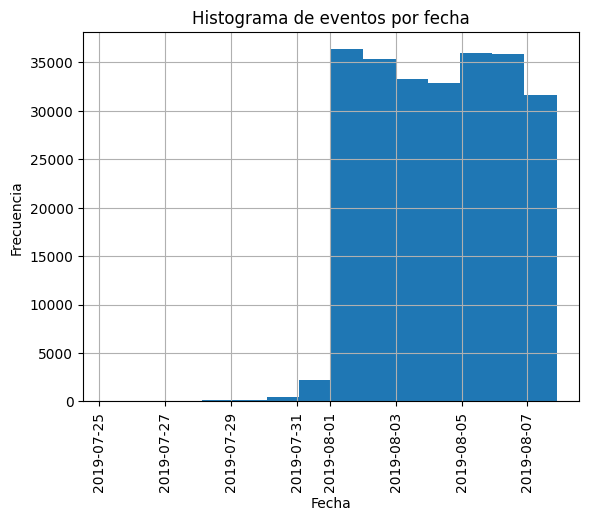

In [12]:
#Histograma por fecha y hora
# Trazar un histograma por fecha y hora
data['hora_event'].hist(bins=14)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Histograma de eventos por fecha')
plt.xticks(rotation=90)
plt.show()

Podemos visualizar que la mayoria de datos se concentra en las fechas del 1 al 7 de agosto. 241298 (mas del 99%) filas pertenecen al mes de agosto y 2828 filas al mes de julio. Por lo que trabajaremos con los datos del solo el mes de agosto ya que los demas datos podrian sesgar el panorama. Ya con esta información con los datos que trabajaremos solo cubre **Una semana**

In [13]:
#Dataset sin valores qu sesgen la información
data_filtrado = data[data['date'] >= '2019-08-01']

In [14]:
data_filtrado.duplicated().sum()

#mostramos las filas con valores duplicados
duplicados = data_filtrado[data_filtrado.duplicated()]
duplicados.head(2)

#Eliminamos datos duplicados
data_filtrado = data_filtrado.drop_duplicates()

In [15]:
data_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   nombre_event        240887 non-null  object        
 1   id_usuario          240887 non-null  int64         
 2   hora_event          240887 non-null  datetime64[ns]
 3   numero_experimento  240887 non-null  int64         
 4   date                240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [16]:
data['nombre_event'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: nombre_event, dtype: int64

In [17]:
data_filtrado['nombre_event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: nombre_event, dtype: int64

In [18]:
#Calculamos la totalidad de eventos para los dateset
print("Total de eventos del dataset original:",data['nombre_event'].count())
print("Total de eventos del dataset filtrado:", data_filtrado['nombre_event'].count())


Total de eventos del dataset original: 244126
Total de eventos del dataset filtrado: 240887


Realmente, No se perdieron muchos eventos solo **2826 eventos** . De los que se perdieron la mayoria (1773) era de "MainScreenAppear".

### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales

In [19]:
data_filtrado.head(2)

,nombre_event,id_usuario,hora_event,numero_experimento,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01


In [20]:
#Cantidad de eventos para cada experimento
users_per_group = data_filtrado.groupby('numero_experimento')['id_usuario'].nunique().reset_index()
users_per_group.columns = ['exp_id', 'users_count']
print("Usuarios por grupo experimental:")
print(users_per_group)

Usuarios por grupo experimental:
   exp_id  users_count
0     246         2484
1     247         2513
2     248         2537


## Estudiar el embudo de eventos

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia

In [21]:
event_counts = data_filtrado['nombre_event'].value_counts().reset_index()
event_counts.columns = ['event', 'count']
print("Frecuencia de eventos:\n", event_counts)

Frecuencia de eventos:
                      event   count
0         MainScreenAppear  117328
1       OffersScreenAppear   46333
2         CartScreenAppear   42303
3  PaymentScreenSuccessful   33918
4                 Tutorial    1005


### Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [22]:
#Cantidad de usuario por evento
usuarios_por_evento = data_filtrado.groupby('nombre_event')['id_usuario'].nunique().reset_index()
usuarios_por_evento.columns = ['evento', 'cant_usuarios']

#Eventos ordenados por el numero de usuarios
usuarios_por_evento = usuarios_por_evento.sort_values(by=['cant_usuarios'], ascending=False)
print('\nCantidad de usuarios por evento\n', usuarios_por_evento)



Cantidad de usuarios por evento
                     evento  cant_usuarios
1         MainScreenAppear           7419
2       OffersScreenAppear           4593
0         CartScreenAppear           3734
3  PaymentScreenSuccessful           3539
4                 Tutorial            840


In [23]:
#Proporción de usuarios que realizaron la acción al menos una vez
usuario = data_filtrado.pivot_table(
    index='id_usuario', 
    columns='nombre_event', 
    values='hora_event',
    aggfunc='min')


In [24]:
paso_1 = ~usuario['MainScreenAppear'].isna()
paso_2 = paso_1 & (usuario['OffersScreenAppear'] > usuario['MainScreenAppear'])
paso_3 = paso_2 & (usuario['CartScreenAppear'] > usuario['OffersScreenAppear'])
paso_4 = paso_3 & (usuario['PaymentScreenSuccessful'] > usuario['CartScreenAppear'])
paso_5 = paso_4 & (usuario['Tutorial'] > usuario['PaymentScreenSuccessful'])

p_principal = usuario[paso_1].shape[0]
p_ofertas = usuario[paso_2].shape[0]
p_carrito = usuario[paso_3].shape[0]
p_pago_exitoso = usuario[paso_4].shape[0]
p_tutorial =  usuario[paso_5].shape[0]

print('Pantalla pricipal:', p_principal)
print('Pantalla ofertas:', p_ofertas)
print('Carrito:', p_carrito)
print('Pago exitoso:', p_pago_exitoso)
print('Tutorial', p_tutorial)

Pantalla pricipal: 7419
Pantalla ofertas: 4201
Carrito: 1767
Pago exitoso: 454
Tutorial 1


Conclusión: No todos los usuarios siguen la ruta predestinada

In [25]:
# Proporción de usuarios por evento.
total_users = data_filtrado['id_usuario'].nunique()
usuarios_por_evento['proporcion'] = usuarios_por_evento['cant_usuarios'] / total_users

print("\nUsuarios por evento:\n", usuarios_por_evento)


Usuarios por evento:
                     evento  cant_usuarios  proporcion
1         MainScreenAppear           7419    0.984736
2       OffersScreenAppear           4593    0.609636
0         CartScreenAppear           3734    0.495620
3  PaymentScreenSuccessful           3539    0.469737
4                 Tutorial            840    0.111495


### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

No creo que tutorial se deba tomar en cuenta

In [26]:
# Eliminamos el evento 'Tutorial'
data_filtrado = data_filtrado[data_filtrado['nombre_event'] != 'Tutorial']
data_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239882 entries, 2829 to 244125
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   nombre_event        239882 non-null  object        
 1   id_usuario          239882 non-null  int64         
 2   hora_event          239882 non-null  datetime64[ns]
 3   numero_experimento  239882 non-null  int64         
 4   date                239882 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


### Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [27]:
# Crear el embudo de eventos
funnel = pd.DataFrame({
    'event': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
    'users': [p_principal, p_ofertas, p_carrito, p_pago_exitoso, p_tutorial]
})

# Calcular proporciones
funnel['proportion'] = funnel['users'] / p_principal
print("\nEmbudo de eventos:\n", funnel)


Embudo de eventos:
                      event  users  proportion
0         MainScreenAppear   7419    1.000000
1       OffersScreenAppear   4201    0.566249
2         CartScreenAppear   1767    0.238172
3  PaymentScreenSuccessful    454    0.061194
4                 Tutorial      1    0.000135


In [28]:
# Calcular proporciones
proporcion_b_a = p_ofertas / p_principal
proporcion_c_b = p_carrito / p_ofertas
proporcion_d_c = p_pago_exitoso / p_carrito


# Mostrar resultados
print(f"Proporción de usuarios que pasan de 'a' a 'b': {proporcion_b_a:.2f}")
print(f"Proporción de usuarios que pasan de 'b' a 'c': {proporcion_c_b:.2f}")
print(f"Proporción de usuarios que pasan de 'c' a 'd': {proporcion_d_c:.2f}")

Proporción de usuarios que pasan de 'a' a 'b': 0.57
Proporción de usuarios que pasan de 'b' a 'c': 0.42
Proporción de usuarios que pasan de 'c' a 'd': 0.26


###  ¿En qué etapa pierdes más usuarios y usuarias?

En la etapa d ( Pantalla de pago exitosa)

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

solo el 6.12% de los usuarios

##  Estudiar los resultados del experimento

### ¿Cuántos usuarios hay en cada grupo?

In [29]:
user_por_group = data_filtrado.groupby('numero_experimento')['id_usuario'].nunique().reset_index()
user_por_group.columns = ['numero_experimento', 'cantidad_users']
print('\nCantidad de usuarios por cada grupo:\n', user_por_group)


Cantidad de usuarios por cada grupo:
    numero_experimento  cantidad_users
0                 246            2483
1                 247            2512
2                 248            2535


### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [30]:
# Contar usuarios únicos por evento y grupo experimental
users_per_event_group = data_filtrado.groupby(['numero_experimento', 'nombre_event'])['id_usuario'].nunique().unstack(fill_value=0)

# verificar datos para los grupos 246 y 247
group_246_events = users_per_event_group.loc[246]
group_247_events = users_per_event_group.loc[247]


In [31]:
# selecciona el evento popular
popular_event = data_filtrado['nombre_event'].mode()[0]

# datos para los grupos 246 y 247
group_246_data = data_filtrado[data_filtrado['numero_experimento'] == 246]
group_247_data = data_filtrado[data_filtrado['numero_experimento'] == 247]

# cantidad de usuarios que realizaron el evento más popular en cada grupo
users_246_event = group_246_data[group_246_data['nombre_event'] == popular_event]['id_usuario'].nunique()
users_247_event = group_247_data[group_247_data['nombre_event'] == popular_event]['id_usuario'].nunique()

# número total de usuarios en cada grupo
total_users_246 = group_246_data['id_usuario'].nunique()
total_users_247 = group_247_data['id_usuario'].nunique()

print("\nDatos de eventos para el grupo 246:\n", group_246_events)
print("\nDatos de eventos para el grupo 247:\n", group_247_events)


Datos de eventos para el grupo 246:
 nombre_event
CartScreenAppear           1266
MainScreenAppear           2450
OffersScreenAppear         1542
PaymentScreenSuccessful    1200
Name: 246, dtype: int64

Datos de eventos para el grupo 247:
 nombre_event
CartScreenAppear           1238
MainScreenAppear           2476
OffersScreenAppear         1520
PaymentScreenSuccessful    1158
Name: 247, dtype: int64


In [32]:
alpha = .05 # nivel de significación

counts = np.array([users_246_event, users_247_event])
nobs = np.array([total_users_246, total_users_247])

# proporción de éxito
p1 = counts[0]/nobs[0]
p2 = counts[1]/nobs[1]

# proporción de éxito en el dataset unido:
p_combined = (counts[0] + counts[1]) / (nobs[0] + nobs[1])

# la diferencia entre las proporciones de los datasets
difference = p1 - p2

# calcula la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/nobs[0] + 1/nobs[1]))

# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  0.7526703436483038
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


**Conclusión:** No hay diferencia significativa entre los grupos 246 y 247

### Repetir el procedimiento para todos los eventos

In [33]:
def compare_proportions(group1_data, group2_data, event):
    
    # cantidad de usuarios que realizaron el evento en cada grupo
    users_group1_event = group1_data[group1_data['nombre_event'] == event]['id_usuario'].nunique()
    users_group2_event = group2_data[group2_data['nombre_event'] == event]['id_usuario'].nunique()

    # número total de usuarios en cada grupo
    total_users_group1 = group1_data['id_usuario'].nunique()
    total_users_group2 = group2_data['id_usuario'].nunique()

    # proporción de usuarios que realizaron el evento en cada grupo
    p1 = users_group1_event / total_users_group1
    p2 = users_group2_event / total_users_group2

    # proporción de usuarios que realizaron el evento en el dataset unido
    p_combined = (users_group1_event + users_group2_event) / (total_users_group1 + total_users_group2)

    # diferencia entre las proporciones de los datasets
    difference = p1 - p2

    # estadística Z
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users_group1 + 1/total_users_group2))

    # p-value
    p_value = (1 - st.norm(0, 1).cdf(abs(z_value))) * 2

    return p1, p2, p_value

In [34]:
alpha = .05  # 5%

events = data_filtrado['nombre_event'].unique()

for event in events:
    p1, p2, p_value = compare_proportions(group_246_data, group_247_data, event)
    print(f"Evento: {event}")
    print(f"Proporción grupo 246: {p1:.2f}")
    print(f"Proporción grupo 247: {p2:.2f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < alpha:
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")
    print()

Evento: MainScreenAppear
Proporción grupo 246: 0.99
Proporción grupo 247: 0.99
p-value: 0.7527
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: OffersScreenAppear
Proporción grupo 246: 0.62
Proporción grupo 247: 0.61
p-value: 0.2479
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: CartScreenAppear
Proporción grupo 246: 0.51
Proporción grupo 247: 0.49
p-value: 0.2287
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: PaymentScreenSuccessful
Proporción grupo 246: 0.48
Proporción grupo 247: 0.46
p-value: 0.1145
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes



### Grupo 248

In [35]:
# datos para el grupo 248
group_248_data = data_filtrado[data_filtrado['numero_experimento'] == 248]

alpha = .05

events = data_filtrado['nombre_event'].unique()

for event in events:
    p1, p2, p_value = compare_proportions(pd.concat([group_246_data, group_247_data], axis=0), group_248_data, event)
    print(f"Evento: {event}")
    print(f"Proporción grupo 246: {p1:.2f}")
    print(f"Proporción grupo 248: {p2:.2f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < alpha:
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")
    print()

Evento: MainScreenAppear
Proporción grupo 246: 0.99
Proporción grupo 248: 0.98
p-value: 0.3487
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: OffersScreenAppear
Proporción grupo 246: 0.61
Proporción grupo 248: 0.60
p-value: 0.4458
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: CartScreenAppear
Proporción grupo 246: 0.50
Proporción grupo 248: 0.49
p-value: 0.1868
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: PaymentScreenSuccessful
Proporción grupo 246: 0.47
Proporción grupo 248: 0.47
p-value: 0.6108
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes



**Conclusión:** Al no haber diferencia significativa entre los grupos 246 y 247 se unen y se comparan con los resultados de 248 en dode se evidencia que en ningun evento de ningun experimento hay una diferencia significativa.

### Nivel de significacion 0.1

In [36]:
alpha = 0.05 / 5  # 5% por evento

for event in events:
    p1, p2, p_value = compare_proportions(pd.concat([group_246_data, group_247_data], axis=0), group_248_data, event)
    print(f"Evento: {event}")
    print(f"Proporción grupo 246: {p1:.2f}")
    print(f"Proporción grupo 248: {p2:.2f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < alpha:
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")
    print()

Evento: MainScreenAppear
Proporción grupo 246: 0.99
Proporción grupo 248: 0.98
p-value: 0.3487
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: OffersScreenAppear
Proporción grupo 246: 0.61
Proporción grupo 248: 0.60
p-value: 0.4458
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: CartScreenAppear
Proporción grupo 246: 0.50
Proporción grupo 248: 0.49
p-value: 0.1868
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Evento: PaymentScreenSuccessful
Proporción grupo 246: 0.47
Proporción grupo 248: 0.47
p-value: 0.6108
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes



## Conclusiones generales:

- Entre los grupos 246 y 247 No hay una diferencia significativa, estableciendo un margen del 0.05%
- Al no haber diferencia entre los grupos A A, se toma la decision de unirlos y compararlos con el grupo 248, en donde tampoco se ve reflejado una diferencia significativa en ningun evento de los grupos.

- Se bajo el nivel de significación (margen del 0.01) y tampoco de ve una diferencia significativa en ninguno de los eventos en ninguno de los grupos.

Por lo tanto, los usuarios no muestran 